# Pangyo AI Challenge 2021 - Mask Classification Baseline

## 라이브러리 호출 및 I/O

In [1]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchcontrib.optim import SWA
import torchcontrib
from torch.optim.swa_utils import SWALR
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [3]:
# 시드(seed) 설정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#seed_everything(100)

In [4]:
# working directory 지정
ROOT_PATH = './'
DATA_DIR = os.path.join(ROOT_PATH, 'pangyo_ai', 'task01_mask', 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'task01_mask_results')
if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
EARLY_STOPPING_PATIENCE = 5
INPUT_SHAPE = (180, 90)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape, augment=False, augtype='imagenet'):

        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        self.augment = augment
        
        if os.path.isfile(os.path.join(RESULT_DIR, 'total.pkl')):
            self.db = pd.read_pickle(os.path.join(RESULT_DIR, 'total.pkl'))
        else:
            self.db = self.data_loader()
            self.db = self.db.sample(frac=1).reset_index()
            self.db.to_pickle(os.path.join(RESULT_DIR, 'total.pkl'))
            
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
        
        policies = [
            transforms.AutoAugmentPolicy.CIFAR10, 
            transforms.AutoAugmentPolicy.IMAGENET, 
            transforms.AutoAugmentPolicy.SVHN
        ]
        dic = {'cifar' : 0, 'imagenet' : 1, 'svhn' :2}
        
        self.transform = transforms.Compose([
            transforms.Resize(self.input_shape), 
            transforms.ToTensor(), 
            transforms.ConvertImageDtype(torch.uint8),
            transforms.AutoAugment(policies[dic[augtype]]),
        ])
        self.transform2 = transforms.Compose([
            transforms.ConvertImageDtype(torch.float),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        self.transform3 = transforms.Compose([
            transforms.Resize(self.input_shape), 
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    
    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
            
        mask_image_list = os.listdir(os.path.join(self.data_dir, 'Mask'))
        nomask_image_list = os.listdir(os.path.join(self.data_dir, 'NoMask'))
        mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
        nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
        mask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'Mask', x), mask_image_list))
        nomask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'NoMask', x), nomask_image_list))

        # encoding label (Mask : 1, No Mask : 0)
        mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
        nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
        db = mask_df.append(nomask_df, ignore_index=True)
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        
        
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = Image.fromarray(cvimg)
        if self.augment == True:
            trans_image = self.transform(trans_image)
            trans_image = self.transform2(trans_image)
        else:
            trans_image = self.transform3(trans_image)

        return trans_image, data['label']

## EarlyStopper

In [6]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int, verbose: bool, logger:logging.RootLogger=None)-> None:
        """ 초기화

        Args:
            patience (int): loss가 줄어들지 않아도 학습할 epoch 수
            weight_path (str): weight 저장경로
            verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        """
        self.patience = patience
        self.verbose = verbose

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.logger = logger
        self.stop = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단

        Args:
            loss (float):

        Examples:
            
        Note:
            
        """  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            # self.save_checkpoint(loss=loss, model=model)

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopper, Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True

            if self.verbose:
                self.logger.info(msg) if self.logger else print(msg)
                
        elif loss <= self.min_loss:
            self.save_model = True
            msg = f"Early stopper, Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
            # self.save_checkpoint(loss=loss, model=model)

            if self.verbose:
                self.logger.info(msg) if self.logger else print(msg)

## Trainer

In [7]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        return epoch_index, self.train_mean_loss, self.train_score, auroc

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
        return self.val_mean_loss, self.validation_score, auroc


## Metrics

In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수"""
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

## 학습을 위한 객체 선언

In [9]:
# Load dataset & dataloader
original_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
imagenet = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE, augment = True, augtype='imagenet')
cifar10 = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE, augment = True, augtype='cifar')
svhn = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE, augment = True, augtype='svhn')

validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)

Dset = [original_dataset, imagenet]
train_dataset = torch.utils.data.ConcatDataset(Dset)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 48776 Val set samples: 2710


## Model

In [10]:
from torch.nn import functional as F
from vit_pytorch import ViT
import timm

In [11]:
# For Multi-GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [12]:
## Predict with ensemble models
class Ensemble(nn.Module):
    def __init__(self, nb_classes=2):
        super(Ensemble, self).__init__()
        self.modelA = timm.create_model(
            'vit_large_patch16_224',
            pretrained=True, 
            img_size=(180, 90),
            num_classes=2
        )
        self.modelB = timm.create_model(
            'eca_nfnet_l1', 
            pretrained=True
        )
        
        # Remove last linear layer
        n_features_A = self.modelA.head.in_features
        self.modelA.head = nn.Identity()
        
        n_features_B = self.modelB.head.fc.in_features
        self.modelB.head.fc = nn.Identity()
        
        # Create new classifier
        self.classifier = nn.Linear(n_features_A + n_features_B, nb_classes)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        
        x = self.classifier(F.relu(x))
        return x

In [13]:
model = Ensemble().to(device)

# Save Initial Model
torch.save({'model':model.state_dict()}, os.path.join(RESULT_DIR, 'initial.pt'))

# Set optimizer, scheduler, loss function, metric function
#SWA_LR = 0.01
#base_opt = optim.SGD(model.parameters(), lr=LEARNING_RATE) #momentum = 0.9, weight_decay = 0.1)
#optimizer = torchcontrib.optim.SWA(base_opt)
#scheduler = SWALR(optimizer, swa_lr=SWA_LR)
#criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-5, last_epoch=-1)
criterion = nn.CrossEntropyLoss()

metric_fn = get_metric_fn

# Set system logger
system_logger = get_logger(name='train',file_path='train_log.log')

# Set trainer
trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE, verbose=True, logger=system_logger)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/ecanfnet_l1_ra2-7dce93cd.pth" to /home/nimdacha/.cache/torch/hub/checkpoints/ecanfnet_l1_ra2-7dce93cd.pth


In [14]:
criterion = 1E+8
epoch_lst = []
train_mean_lst = []
train_acc_lst = []
train_auroc_lst = []

val_mean_lst = []
val_acc_lst = []
val_auroc_lst = []

for epoch_index in tqdm(range(EPOCHS)):

    epoch_index, mean_loss, acc, auroc = trainer.train_epoch(train_dataloader, epoch_index)
    epoch_lst.append(epoch_index)
    train_mean_lst.append(mean_loss)
    train_acc_lst.append(acc)
    train_auroc_lst.append(auroc)
    
    mean_loss, acc, auroc = trainer.validate_epoch(validation_dataloader, epoch_index)
    val_mean_lst.append(mean_loss)
    val_acc_lst.append(acc)
    val_auroc_lst.append(auroc)
    
    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if trainer.val_mean_loss < criterion:
        criterion = trainer.val_mean_loss
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, os.path.join(RESULT_DIR, 'best.pt'))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.15682382533624314, Acc: 0.9368746924717074, ROC: 0.984093299941352
Epoch 0, Val loss: 0.09516692900005178, Acc: 0.9653136531365314, ROC: 0.9944952509615252


  5%|▌         | 1/20 [11:24<3:36:51, 684.81s/it]

Epoch 1, Train loss: 0.05037959301367196, Acc: 0.9824708873216336, ROC: 0.9980911832463532


 10%|█         | 2/20 [22:38<3:23:29, 678.29s/it]

Epoch 1, Val loss: 0.10031694749035437, Acc: 0.966789667896679, ROC: 0.9953339490770736
Epoch 2, Train loss: 0.027176491725908174, Acc: 0.9900155814334919, ROC: 0.9994986913711108
Epoch 2, Val loss: 0.08738084475820461, Acc: 0.9738007380073801, ROC: 0.997344398340249


 15%|█▌        | 3/20 [33:56<3:12:05, 677.96s/it]

Epoch 3, Train loss: 0.02630534184920333, Acc: 0.9905076267016566, ROC: 0.9995040897322688
Epoch 3, Val loss: 0.08420388536694712, Acc: 0.9756457564575646, ROC: 0.9973956796845922


 20%|██        | 4/20 [45:18<3:01:13, 679.59s/it]

Epoch 4, Train loss: 0.02108614701062945, Acc: 0.9925988190913564, ROC: 0.999665079403795
Epoch 4, Val loss: 0.07386588241228546, Acc: 0.977859778597786, ROC: 0.9976167960188033


 25%|██▌       | 5/20 [56:41<2:50:11, 680.79s/it]

Epoch 5, Train loss: 0.012599065528866499, Acc: 0.9951820567492209, ROC: 0.9998865672376045


 30%|███       | 6/20 [1:07:55<2:38:18, 678.49s/it]

Epoch 5, Val loss: 0.07479551008202029, Acc: 0.9830258302583026, ROC: 0.9981841992804069
Epoch 6, Train loss: 0.014015951411570837, Acc: 0.9955100869279974, ROC: 0.9998373170964961


 35%|███▌      | 7/20 [1:19:10<2:26:45, 677.31s/it]

Epoch 6, Val loss: 0.11440171736952956, Acc: 0.9767527675276753, ROC: 0.9968282764229884
Epoch 7, Train loss: 0.019655662389430697, Acc: 0.9935009020829917, ROC: 0.9996829074312318


 40%|████      | 8/20 [1:35:39<2:35:20, 776.68s/it]

Epoch 7, Val loss: 0.12908724668558313, Acc: 0.9712177121771217, ROC: 0.9966926289960161
Epoch 8, Train loss: 0.015568507134561684, Acc: 0.9949770378874856, ROC: 0.9997898153078368


 40%|████      | 8/20 [1:56:06<2:54:09, 870.77s/it]

Epoch 8, Val loss: 0.10892425993593934, Acc: 0.9752767527675277, ROC: 0.9974397926689733
Early stopped


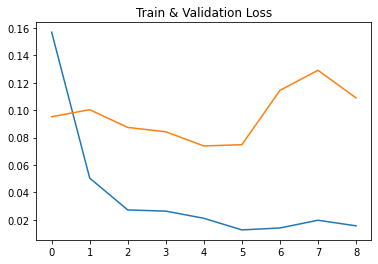

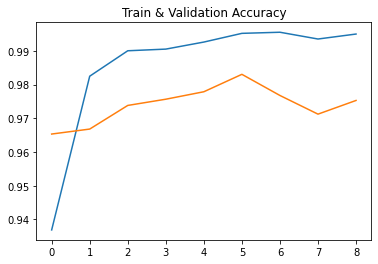

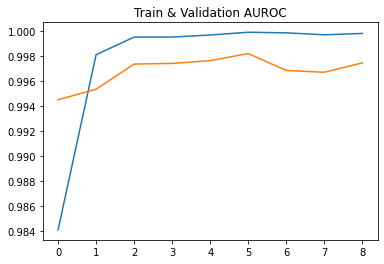

In [15]:
import matplotlib.pyplot as plt

plt.plot(epoch_lst, train_mean_lst)
plt.plot(epoch_lst, val_mean_lst)
plt.title("Train & Validation Loss")
plt.show()

plt.plot(epoch_lst, train_acc_lst)
plt.plot(epoch_lst, val_acc_lst)
plt.title("Train & Validation Accuracy")
plt.show()

plt.plot(epoch_lst, train_auroc_lst)
plt.plot(epoch_lst, val_auroc_lst)
plt.title("Train & Validation AUROC")
plt.show()

## Inference

In [16]:
TRAINED_MODEL_PATH = os.path.join(RESULT_DIR, 'best.pt')

#### Test set Loader

In [17]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([
            transforms.Resize(self.input_shape), 
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']
    
    def data_loader(self):
        print('Loading ' + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()

        mask_image_list = os.listdir(os.path.join(self.data_dir, 'Mask'))
        nomask_image_list = os.listdir(os.path.join(self.data_dir, 'NoMask'))
        mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
        nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
        mask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'Mask', x), mask_image_list))
        nomask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'NoMask', x), nomask_image_list))

        # encoding label (Mask : 1, No Mask : 0)
        mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
        nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
        db = mask_df.append(nomask_df, ignore_index=True)
        return db

In [18]:
DATA_DIR=os.path.join(ROOT_PATH, 'pangyo_ai', 'task01_mask', 'test_annot')

# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading  dataset..


In [19]:
# We made..
if os.path.isfile(os.path.join(DATA_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(DATA_DIR, 'test.pkl'))
else:
    test_db = TestDataset.labeling()
    test_db.to_pickle(os.path.join(DATA_DIR, 'test.pkl'))

In [20]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_num_lst = []
pred_lst = []
prob_lst = []
target_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, label) in enumerate(test_dataloader):
        img = img.to(device)
        pred = model(img)
        #file_num_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())
        target_lst.extend(label.cpu().tolist())

acc, roc = get_metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
print('Accuracy: ', acc, ', ', 'AUROC: ', roc)

Accuracy:  0.8362573099415205 ,  AUROC:  0.9082148562300321


In [21]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([
            transforms.Resize(self.input_shape), 
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [22]:
DATA_DIR=os.path.join(ROOT_PATH, 'pangyo_ai', 'task01_mask', 'test')

# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


In [23]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_num_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in enumerate(test_dataloader):
        img = img.to(device)
        pred = model(img)
        file_num_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

#### Save results as csv file

In [24]:
df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
df.sort_values(by=['file_name'], inplace=True)
df.to_csv(os.path.join(RESULT_DIR, 'mask_pred.csv'), index=False)